# Experiment 1: Cross-Agent Comparison Analysis

This notebook analyzes MCP performance across different coding agents (goose-cli, claude-code, gemini-cli).

**Objective:** Determine whether agent choice affects MCP retrieval performance.

**See:** `notes/experiment_1_cross_agent_comparison.md` for detailed experimental design.

In [1]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Load Results from Different Agents

In [2]:
# Define result files for each agent
result_files = {
    'goose': '../results/compare_agents/goose_20251103.yaml',  # Fixed with MCP extensions (COMPLETE)
    'claude': '../results/compare_agents/claude_20251031.yaml',  # Claude Code results
    # Uncomment when available:
    # 'gemini': '../results/compare_agents/gemini_YYYYMMDD.yaml',
}

# Load results
agent_results = {}
for agent, filepath in result_files.items():
    if Path(filepath).exists():
        with open(filepath, 'r') as f:
            agent_results[agent] = yaml.safe_load(f)
        print(f"✓ Loaded results for {agent}: {filepath}")
    else:
        print(f"✗ Results not found for {agent}: {filepath}")

print(f"\n{len(agent_results)} agent(s) loaded: {list(agent_results.keys())}")

✓ Loaded results for goose: ../results/compare_agents/goose_20251103.yaml


✓ Loaded results for claude: ../results/compare_agents/claude_20251031.yaml

2 agent(s) loaded: ['goose', 'claude']


## Convert to DataFrames

In [3]:
# Convert each agent's results to DataFrame
dfs = {}
for agent, results in agent_results.items():
    df = pd.DataFrame(results['results'])
    df = df.explode('servers')  # Expand so each server gets its own row
    df['MCP'] = df['servers']
    df['agent'] = agent  # Add agent identifier
    dfs[agent] = df

# Combine all results into single DataFrame
if dfs:
    df_combined = pd.concat(dfs.values(), ignore_index=True)
    print(f"Combined dataset shape: {df_combined.shape}")
    print(f"\nAgents: {df_combined['agent'].unique()}")
    print(f"MCPs: {df_combined['MCP'].unique()}")
    print(f"Case groups: {df_combined['case_group'].unique()}")
else:
    print("No results loaded yet. Run experiments first.")

Combined dataset shape: (200, 16)

Agents: ['goose' 'claude']
MCPs: ['artl' 'simple-pubmed' 'biomcp' 'pubmed-mcp']
Case groups: ['Text extraction' 'Metadata' 'Summarization'
 'Table / Figure / Figure Legend extraction' 'Supplementary material'
 'Publication status']


## 1. Overall Performance by Agent

Compare pass rates across agents for each MCP.

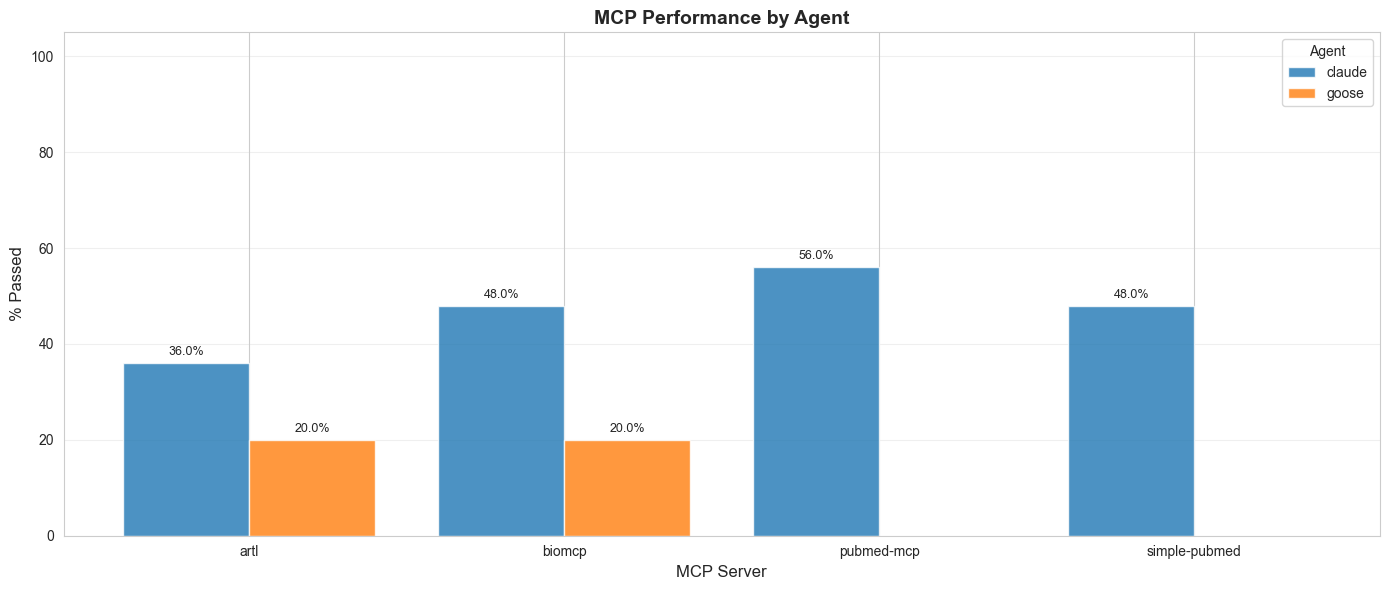


Pass Rates by MCP and Agent:
agent          claude  goose
MCP                         
artl             36.0   20.0
biomcp           48.0   20.0
pubmed-mcp       56.0    0.0
simple-pubmed    48.0    0.0


In [4]:
if 'df_combined' in locals():
    # Calculate % passed by MCP and agent
    pass_rates = df_combined.groupby(['agent', 'MCP'])['passed'].mean().reset_index()
    pass_rates['percent_passed'] = pass_rates['passed'] * 100

    # Create grouped bar chart
    fig, ax = plt.subplots(figsize=(14, 6))
    
    mcps = pass_rates['MCP'].unique()
    agents = pass_rates['agent'].unique()
    x = np.arange(len(mcps))
    width = 0.8 / len(agents)
    
    for i, agent in enumerate(agents):
        agent_data = pass_rates[pass_rates['agent'] == agent]
        heights = [agent_data[agent_data['MCP'] == mcp]['percent_passed'].values[0] if len(agent_data[agent_data['MCP'] == mcp]) > 0 else 0 for mcp in mcps]
        bars = ax.bar(x + i * width, heights, width, label=agent, alpha=0.8)
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2, height + 1,
                       f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
    
    ax.set_xlabel('MCP Server', fontsize=12)
    ax.set_ylabel('% Passed', fontsize=12)
    ax.set_title('MCP Performance by Agent', fontsize=14, fontweight='bold')
    ax.set_xticks(x + width * (len(agents) - 1) / 2)
    ax.set_xticklabels(mcps)
    ax.set_ylim(0, 105)
    ax.legend(title='Agent')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../results/figures/exp1_overall_performance_by_agent.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary table
    print("\nPass Rates by MCP and Agent:")
    print(pass_rates.pivot(index='MCP', columns='agent', values='percent_passed').round(1))

## 2. Case Group Performance Heatmap

Identify which task types are agent-sensitive.

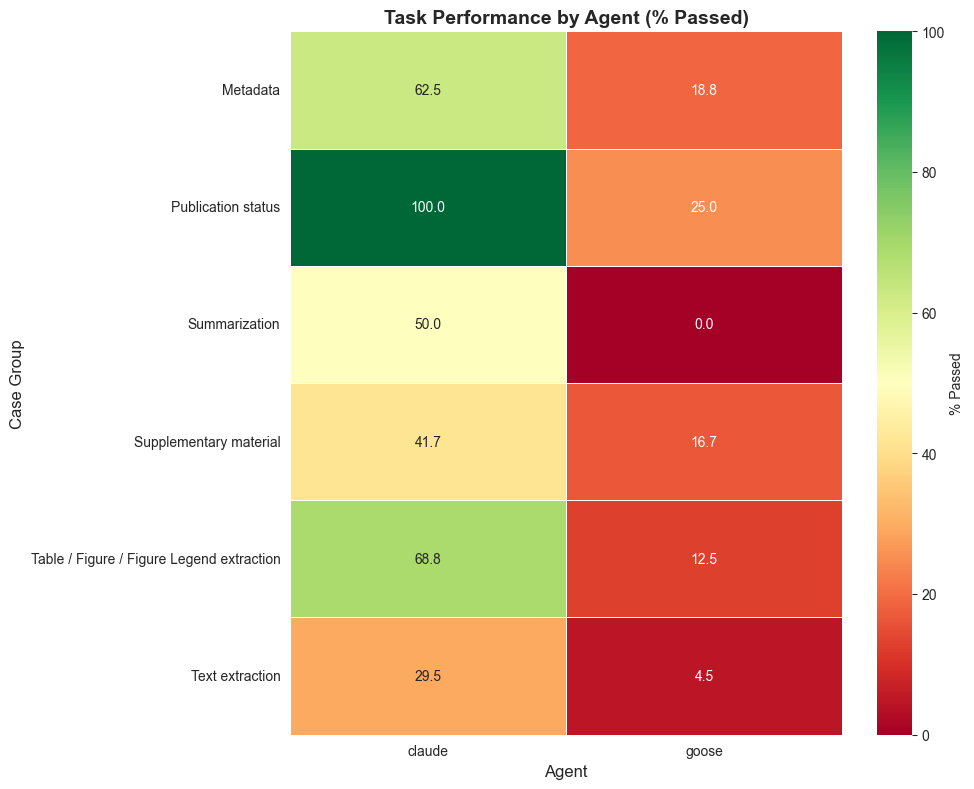


Case Group Performance:
agent                                      claude  goose
case_group                                              
Metadata                                     62.5   18.8
Publication status                          100.0   25.0
Summarization                                50.0    0.0
Supplementary material                       41.7   16.7
Table / Figure / Figure Legend extraction    68.8   12.5
Text extraction                              29.5    4.5


In [5]:
if 'df_combined' in locals():
    # Calculate % passed by case_group and agent
    group_pass_rates = df_combined.groupby(['case_group', 'agent'])['passed'].mean().reset_index()
    group_pass_rates['percent_passed'] = group_pass_rates['passed'] * 100
    
    # Pivot for heatmap
    heatmap_data = group_pass_rates.pivot(index='case_group', columns='agent', values='percent_passed')
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn', 
                vmin=0, vmax=100, cbar_kws={'label': '% Passed'},
                linewidths=0.5, ax=ax)
    ax.set_title('Task Performance by Agent (% Passed)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Agent', fontsize=12)
    ax.set_ylabel('Case Group', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('../results/figures/exp1_case_group_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nCase Group Performance:")
    print(heatmap_data.round(1))

## 3. Score Distribution Comparison

Compare semantic similarity score distributions across agents.

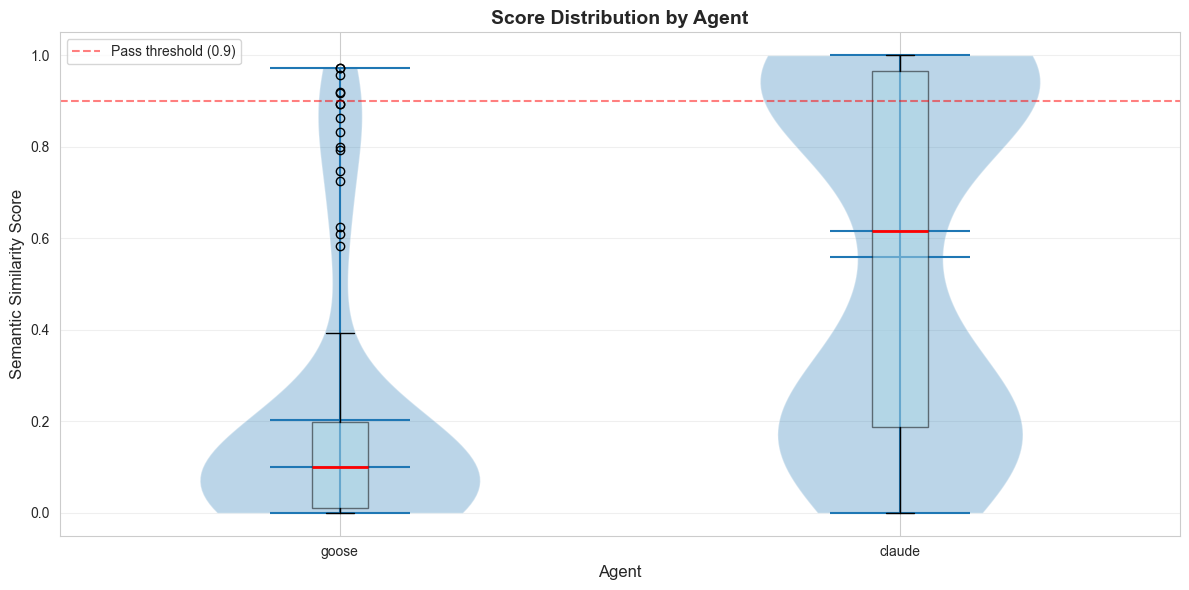


Score Statistics by Agent:
        count   mean    std  min    25%    50%    75%    max
agent                                                       
claude  100.0  0.559  0.388  0.0  0.188  0.616  0.965  1.000
goose   100.0  0.203  0.285  0.0  0.010  0.099  0.199  0.973


In [6]:
if 'df_combined' in locals():
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Create violin plots
    parts = ax.violinplot([df_combined[df_combined['agent'] == agent]['score'].dropna() 
                           for agent in df_combined['agent'].unique()],
                          positions=range(len(df_combined['agent'].unique())),
                          showmeans=True, showmedians=True)
    
    # Overlay box plots
    bp = ax.boxplot([df_combined[df_combined['agent'] == agent]['score'].dropna() 
                     for agent in df_combined['agent'].unique()],
                    positions=range(len(df_combined['agent'].unique())),
                    widths=0.1, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.5),
                    medianprops=dict(color='red', linewidth=2))
    
    ax.set_xticks(range(len(df_combined['agent'].unique())))
    ax.set_xticklabels(df_combined['agent'].unique())
    ax.set_ylabel('Semantic Similarity Score', fontsize=12)
    ax.set_xlabel('Agent', fontsize=12)
    ax.set_title('Score Distribution by Agent', fontsize=14, fontweight='bold')
    ax.axhline(y=0.9, color='red', linestyle='--', alpha=0.5, label='Pass threshold (0.9)')
    ax.set_ylim(-0.05, 1.05)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../results/figures/exp1_score_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\nScore Statistics by Agent:")
    print(df_combined.groupby('agent')['score'].describe().round(3))

## 4. Error Rate Analysis

Compare error rates and execution stability across agents.


Execution Summary by Agent:
        passed_count  total_count  error_count  failed_count  pass_rate  \
agent                                                                     
claude            47          100            0            53       47.0   
goose             10          100            0            90       10.0   

        error_rate  
agent               
claude         0.0  
goose          0.0  


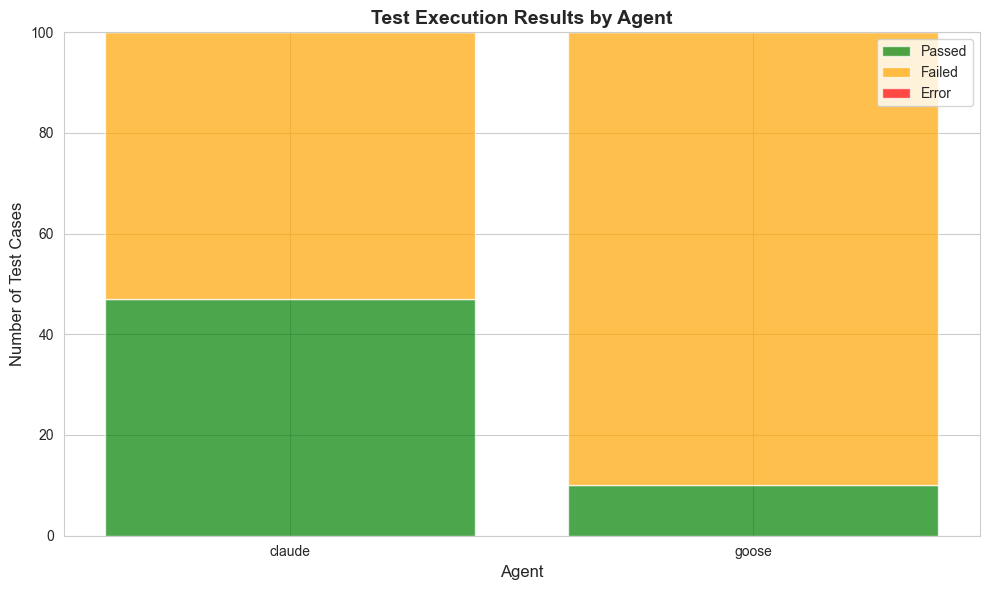

In [7]:
if 'df_combined' in locals():
    # Calculate error rates (assuming 'error' column exists or we infer from missing scores)
    error_analysis = df_combined.groupby('agent').agg({
        'passed': ['sum', 'count'],
        'score': lambda x: x.isna().sum()  # Count missing scores as errors
    }).round(2)
    
    error_analysis.columns = ['passed_count', 'total_count', 'error_count']
    error_analysis['failed_count'] = error_analysis['total_count'] - error_analysis['passed_count'] - error_analysis['error_count']
    error_analysis['pass_rate'] = (error_analysis['passed_count'] / error_analysis['total_count'] * 100).round(1)
    error_analysis['error_rate'] = (error_analysis['error_count'] / error_analysis['total_count'] * 100).round(1)
    
    print("\nExecution Summary by Agent:")
    print(error_analysis)
    
    # Stacked bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    
    agents = error_analysis.index
    x = np.arange(len(agents))
    
    p1 = ax.bar(x, error_analysis['passed_count'], label='Passed', color='green', alpha=0.7)
    p2 = ax.bar(x, error_analysis['failed_count'], bottom=error_analysis['passed_count'],
               label='Failed', color='orange', alpha=0.7)
    p3 = ax.bar(x, error_analysis['error_count'], 
               bottom=error_analysis['passed_count'] + error_analysis['failed_count'],
               label='Error', color='red', alpha=0.7)
    
    ax.set_ylabel('Number of Test Cases', fontsize=12)
    ax.set_xlabel('Agent', fontsize=12)
    ax.set_title('Test Execution Results by Agent', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(agents)
    ax.legend()
    
    plt.tight_layout()
    plt.savefig('../results/figures/exp1_error_rates.png', dpi=300, bbox_inches='tight')
    plt.show()

## 5. Statistical Tests

Test whether differences between agents are statistically significant.

In [ ]:
if 'df_combined' in locals() and len(df_combined['agent'].unique()) > 1:
    from scipy.stats import chi2_contingency, mannwhitneyu
    
    # Chi-square test for pass/fail independence
    print("Chi-square test for agent × pass/fail independence:")
    contingency_table = pd.crosstab(df_combined['agent'], df_combined['passed'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f"  χ² = {chi2:.3f}, p = {p_value:.4f}, df = {dof}")
    print(f"  Result: {'Significant' if p_value < 0.05 else 'Not significant'} at α=0.05\n")
    
    # Mann-Whitney U test for score distributions (unpaired comparison)
    agents = df_combined['agent'].unique()
    if len(agents) >= 2:
        print("\nPairwise Mann-Whitney U tests for score distributions:")
        for i in range(len(agents)):
            for j in range(i+1, len(agents)):
                agent1_scores = df_combined[df_combined['agent'] == agents[i]]['score'].dropna()
                agent2_scores = df_combined[df_combined['agent'] == agents[j]]['score'].dropna()
                
                if len(agent1_scores) > 0 and len(agent2_scores) > 0:
                    stat, p = mannwhitneyu(agent1_scores, agent2_scores, alternative='two-sided')
                    print(f"  {agents[i]} vs {agents[j]}: U = {stat:.1f}, p = {p:.4f}")
                    print(f"    Median scores: {agent1_scores.median():.3f} vs {agent2_scores.median():.3f}")
                    print(f"    Result: {'Significant' if p < 0.05 else 'Not significant'} at α=0.05\n")

## 6. Key Findings Summary

In [9]:
if 'df_combined' in locals():
    print("="*70)
    print("KEY FINDINGS: Cross-Agent Comparison")
    print("="*70)
    
    overall_pass_rates = df_combined.groupby('agent')['passed'].mean() * 100
    print("\n1. Overall Pass Rates:")
    for agent, rate in overall_pass_rates.items():
        print(f"   {agent}: {rate:.1f}%")
    
    max_diff = overall_pass_rates.max() - overall_pass_rates.min()
    print(f"\n   Max difference: {max_diff:.1f} percentage points")
    
    if max_diff > 20:
        print("   → Agent choice SIGNIFICANTLY affects performance")
    elif max_diff > 5:
        print("   → Agent choice MODERATELY affects performance")
    else:
        print("   → Agent choice has MINIMAL effect on performance")
    
    print("\n2. Most Agent-Sensitive Case Groups:")
    if 'heatmap_data' in locals():
        variance_by_group = heatmap_data.var(axis=1).sort_values(ascending=False)
        for group, var in variance_by_group.head(3).items():
            print(f"   {group}: variance = {var:.1f}")
    
    print("\n" + "="*70)

KEY FINDINGS: Cross-Agent Comparison

1. Overall Pass Rates:
   claude: 47.0%
   goose: 10.0%

   Max difference: 37.0 percentage points
   → Agent choice SIGNIFICANTLY affects performance

2. Most Agent-Sensitive Case Groups:
   Publication status: variance = 2812.5
   Table / Figure / Figure Legend extraction: variance = 1582.0
   Summarization: variance = 1250.0



## Next Steps

1. **If agent choice matters significantly:** Investigate specific failure cases to understand why
2. **If agent choice doesn't matter:** Current baseline results likely reflect true MCP capabilities
3. **Export findings** for manuscript integration (see `notes/experiment_1_cross_agent_comparison.md`)